In [1]:
import torch
import pandas as pd
path = "https://pages.cs.wisc.edu/~harter/cs639/data/wi-stations/USW00014837.csv.gz"
df = pd.read_csv(path, names=["station", "date", "element", "value", "m", "q", "s", "obs"])

#https://pages.cs.wisc.edu/~harter/cs639/data/wi-stations/USW00014839.csv.gz

/tmp/ipykernel_7646/1724107054.py:4: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path, names=["station", "date", "element", "value", "m", "q", "s", "obs"])


In [2]:
df["element"].isin(["TMIN", "TMAX"])

0          True
1          True
2          True
3          True
4          True
          ...  
409846    False
409847    False
409848    False
409849    False
409850    False
Name: element, Length: 409851, dtype: bool

In [3]:
df2 = df[df["element"].isin(["TMIN", "TMAX"])]
df2.head()

,station,date,element,value,m,q,s,obs
0,USW00014837,19391001,TMAX,194,NaN,NaN,X,NaN
1,USW00014837,19391002,TMAX,211,NaN,NaN,X,NaN
2,USW00014837,19391003,TMAX,233,NaN,NaN,X,NaN
3,USW00014837,19391004,TMAX,272,NaN,NaN,X,NaN
4,USW00014837,19391005,TMAX,211,NaN,NaN,X,NaN


In [4]:
# GOAL: predict TMAX given TMIN
temps = df2.pivot(index="date", columns="element", values="value")
temps.head()

element,TMAX,TMIN
date,,
19391001,194,6
19391002,211,33
19391003,233,89
19391004,272,106
19391005,211,133


<AxesSubplot: xlabel='TMIN', ylabel='TMAX'>

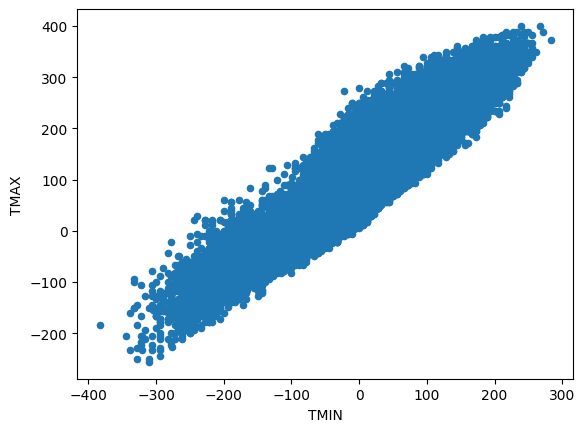

In [5]:
temps.plot.scatter(x="TMIN", y="TMAX")

In [6]:
# PyTorch Data:
# 1. Dataset
# 2. DataLoader: use DataSet, but provide shuffling and batching

In [7]:
import torch
torch.tensor(temps[["TMAX"]].values, dtype=torch.float32)

tensor([[194.],
        [211.],
        [233.],
        ...,
        [ 28.],
        [ 22.],
        [  0.]])

In [8]:
# all data is in memory at the same time
ds = torch.utils.data.TensorDataset(
    torch.tensor(temps[["TMIN"]].values, dtype=torch.float32),
    torch.tensor(temps[["TMAX"]].values, dtype=torch.float32))

In [9]:
ds[1]

(tensor([33.]), tensor([211.]))

In [10]:
type(ds).__mro__

(torch.utils.data.dataset.TensorDataset,
 torch.utils.data.dataset.Dataset,
 typing.Generic,
 object)

In [11]:
class TempDS(torch.utils.data.dataset.Dataset):
    def __init__(self, path):
        df = pd.read_csv(path, names=["station", "date", "element", "value", "m", "q", "s", "obs"])
        df2 = df[df["element"].isin(["TMIN", "TMAX"])]
        temps = df2.pivot(index="date", columns="element", values="value")
        self.X = torch.tensor(temps[["TMIN"]].values, dtype=torch.float32)
        self.Y = torch.tensor(temps[["TMAX"]].values, dtype=torch.float32)
        
    def __getitem__(self, index):
        return self.X[index], self.Y[index]
    
    def __len__(self):
        return len(self.X)

ds = TempDS("https://pages.cs.wisc.edu/~harter/cs639/data/wi-stations/USW00014837.csv.gz")

/tmp/ipykernel_7646/841781102.py:3: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path, names=["station", "date", "element", "value", "m", "q", "s", "obs"])


In [12]:
ds[1]

(tensor([33.]), tensor([211.]))

In [13]:
ds[:5]

(tensor([[  6.],
         [ 33.],
         [ 89.],
         [106.],
         [133.]]),
 tensor([[194.],
         [211.],
         [233.],
         [272.],
         [211.]]))

In [14]:
ds[:]

(tensor([[  6.],
         [ 33.],
         [ 89.],
         ...,
         [  0.],
         [  0.],
         [-32.]]),
 tensor([[194.],
         [211.],
         [233.],
         ...,
         [ 28.],
         [ 22.],
         [  0.]]))

In [15]:
len(ds)

30428

In [16]:
ds2 = TempDS("https://pages.cs.wisc.edu/~harter/cs639/data/wi-stations/USW00014839.csv.gz")

/tmp/ipykernel_7646/841781102.py:3: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path, names=["station", "date", "element", "value", "m", "q", "s", "obs"])


In [17]:
len(ds + ds2)

61404

In [18]:
dl = torch.utils.data.DataLoader(ds, shuffle=True, batch_size=10)

In [19]:
for x, y in dl:
    print(x)
    print(y)
    break

tensor([[ -27.],
        [ -32.],
        [  22.],
        [-111.],
        [-239.],
        [   0.],
        [ 161.],
        [-217.],
        [ -27.],
        [ -78.]])
tensor([[  61.],
        [   0.],
        [ 178.],
        [  28.],
        [-161.],
        [  83.],
        [ 261.],
        [ -89.],
        [  67.],
        [  11.]])


In [20]:
# review: Dataset, DataLoader, Model, Optimizer, Loss Function

# model:
# tmax = model(tmin) = tmin * weight + bias

In [26]:
model = torch.nn.Linear(1, 1)
optimizer = torch.optim.SGD([model.weight, model.bias], lr=0.00001)
loss_fn = torch.nn.MSELoss()

for epoch in range(50):
    for batchx, batchy in dl:
        predictedy = model(batchx)
        loss = loss_fn(batchy, predictedy)
        loss.backward()         # update weight.grad and bias.grad
        optimizer.step()        # update weight and bias based on the gradients
        optimizer.zero_grad()   # weight.grad = 0 and bias.grad = 0
        # TODO: change model params based on loss
    # how well are we doing?
    x, y = ds[:]
    print(epoch, loss_fn(y, model(x)))

0 tensor(12819.2314, grad_fn=<MseLossBackward0>)
1 tensor(11452.3125, grad_fn=<MseLossBackward0>)
2 tensor(10781.9971, grad_fn=<MseLossBackward0>)
3 tensor(9431.9297, grad_fn=<MseLossBackward0>)
4 tensor(8612.9014, grad_fn=<MseLossBackward0>)
5 tensor(7942.2290, grad_fn=<MseLossBackward0>)
6 tensor(7272.4038, grad_fn=<MseLossBackward0>)
7 tensor(6834.5107, grad_fn=<MseLossBackward0>)
8 tensor(6377.7363, grad_fn=<MseLossBackward0>)
9 tensor(5725.4956, grad_fn=<MseLossBackward0>)
10 tensor(5329.7026, grad_fn=<MseLossBackward0>)
11 tensor(5077.4556, grad_fn=<MseLossBackward0>)
12 tensor(4675.3706, grad_fn=<MseLossBackward0>)
13 tensor(4512.1616, grad_fn=<MseLossBackward0>)
14 tensor(4132.9248, grad_fn=<MseLossBackward0>)
15 tensor(3877.8147, grad_fn=<MseLossBackward0>)
16 tensor(3682.7371, grad_fn=<MseLossBackward0>)
17 tensor(3504.5417, grad_fn=<MseLossBackward0>)
18 tensor(3396.3645, grad_fn=<MseLossBackward0>)
19 tensor(3201.0447, grad_fn=<MseLossBackward0>)
20 tensor(3151.0110, grad_f

In [27]:
model.weight, model.bias

(Parameter containing:
 tensor([[1.0198]], requires_grad=True),
 Parameter containing:
 tensor([105.4057], requires_grad=True))

In [35]:
model.weight.dtype

torch.float32

In [38]:
tmin = torch.arange(-400, 300, dtype=torch.float32)
predicted_tmax = model(tmin.reshape(-1, 1)).reshape(-1)

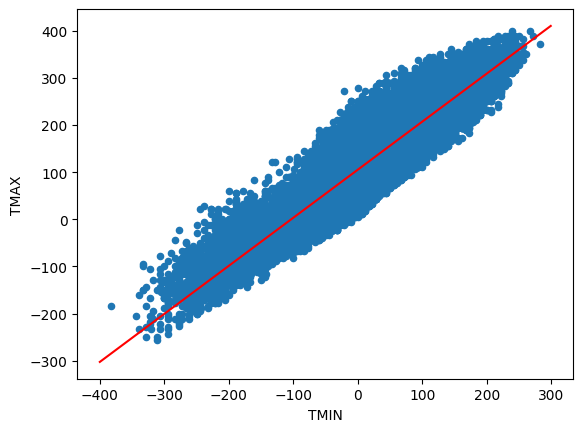

In [41]:
import matplotlib.pyplot as plt
temps.plot.scatter(x="TMIN", y="TMAX")
plt.plot(tmin, predicted_tmax.detach(), "r")